In [1]:
# %matplotlib ipympl
# %matplotlib notebook

# GRP Hopper

https://ieeexplore.ieee.org/document/7989248

## Simplified Version

In [2]:
import os
# Get current working directory
cwd = os.getcwd()

# Only go up one level if we’re currently inside 'notebooks'
if cwd.endswith("notebooks"):
    os.chdir("..")
print("Current working directory:", os.getcwd())

Current working directory: /Users/jerrywu/Desktop/hopper_sim


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from models.GRP_hopper_simplified import simplified_GRP_hopper

# ======================================================
# Load config
# ======================================================
with open("cfg/GRP_hopper_simplified.yaml", "r") as f:
    cfg = yaml.safe_load(f)["simplified_GRP_hopper"]

mb = cfg["mb"]
mf = cfg["mf"]
l0 = cfg["l0"]
g  = cfg["g"]
x0 = np.array(cfg["x0"][0])
# Create hopper model
hopper = simplified_GRP_hopper(mb, mf, l0, g)

# ======================================================
# Create NLP controller
# ======================================================
nlp_cfg = cfg["controller"]["NLP"]
dt_control = nlp_cfg["dt_control"]
H  = nlp_cfg["H"]
u_min = nlp_cfg["u_min"]
u_max = nlp_cfg["u_max"]
R_u   = nlp_cfg["R_u"]
Q_bh  = nlp_cfg["Q_bh"]
Q_bv  = nlp_cfg["Q_bv"]
Q_fh  = nlp_cfg["Q_fh"]
Q_fv  = nlp_cfg["Q_fv"]
Q_l   = nlp_cfg["Q_l"]
body_ref = nlp_cfg["body_ref"]
body_vref = nlp_cfg["body_vref"]
foot_ref = nlp_cfg["foot_ref"]
foot_vref = nlp_cfg["foot_vref"]

# Initial guess: all flight
mode_seq0 = ["flight"] * H

nlp = simplified_GRP_hopper.NLPController(
    hopper=hopper,
    H=H,
    dt=dt_control,
    x0=x0,
    mode_seq=mode_seq0,
    u_min=u_min,
    u_max=u_max,
    R_u=R_u,
    Q_bh=Q_bh,
    Q_bv=Q_bv,
    Q_fh=Q_fh,
    Q_fv=Q_fv,
    Q_l=Q_l,
    body_ref=body_ref,
    body_vref=body_vref,
    foot_ref=foot_ref,
    foot_vref=foot_vref,
)

# ======================================================
# Simulation settings
# ======================================================
sim_cfg = cfg["simulation"]
T_sim = sim_cfg["t_max"]
dt_sim = sim_cfg["dt"]
N_sim = int(T_sim / dt_sim)

x_hist = np.zeros((N_sim, 4))
u_hist = np.zeros(N_sim)
mode_hist = []

# initial data
x = x0.copy()
warm_start = None

# Set initial mode based on foot position
if x[2] <= 1e-4:
    current_mode = "stance"
else:
    current_mode = "flight"
    
print(f"Initial mode: {current_mode}")

Initial mode: stance


In [4]:
# ======================================================
# Simulation Loop (Final Version Matching Your API)
# ======================================================
for k in range(N_sim):

    # --------------------------------------------------
    # 1) Predict mode sequence using internal hopper + dt + H
    # --------------------------------------------------
    # Use gravity compensation as u_guess to enable liftoff prediction
    u_guess = hopper.mb * hopper.g + 20.0  # gravity compensation + extra for liftoff
    
    mode_seq = nlp.predict_mode_sequence(
        x_current=x,
        state_current=current_mode,
        stance_duration=0.10,  # shorter stance for more dynamic hopping
        u_guess=u_guess
    )

    mode_hist.append(mode_seq[0])

    nlp.update_mode_sequence(mode_seq)

    # --------------------------------------------------
    # 2) Solve NLP
    # --------------------------------------------------
    u, warm_start = nlp.compute(
        x_current=x,
        warm_start=warm_start,
        return_warm_start=True
    )
    u_hist[k] = u

    # --------------------------------------------------
    # 3) Apply hopper dynamics for dt_sim
    # --------------------------------------------------
    if current_mode == "flight":
        f, _ = hopper.flight_state(x, u)
    else:
        f, _ = hopper.stance_state(x, u)

    x = x + dt_sim * f
    
    # Safety: prevent ground penetration
    x[0] = max(x[0], 0.0001)  # body must be above ground
    x[2] = max(x[2], 0.0)     # foot must be at or above ground
    x[0] = max(x[0], x[2])    # body must be above foot
    
    x_hist[k] = x

    # --------------------------------------------------
    # 4) Real physical mode update (based on actual state)
    # --------------------------------------------------
    leg_length = x[0] - x[2]  # body height - foot height
    
    if current_mode == "stance":
        # Liftoff condition: leg extends beyond threshold OR foot tries to go above ground
        if leg_length >= l0 * 1.05 or x[2] > 1e-4:
            current_mode = "flight"
            print(f"LIFTOFF at t={k*dt_sim:.3f}s, leg_length={leg_length:.3f}m")
    else:  # flight
        # Touchdown condition: foot touches ground
        if x[2] <= 1e-4:
            current_mode = "stance"
            print(f"TOUCHDOWN at t={k*dt_sim:.3f}s")



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

LIFTOFF at t=0.064s, leg_length=0.316m
TOUCHDOWN at t=0.065s
LIFTOFF at t=0.066s, leg_length=0.319m
TOUCHDOWN at t=0.067s
LIFTOFF at t=0.068s, leg_length=0.322m
TOUCHDOWN at t=1.192s
LIFTOFF at t=1.679s, leg_length=0.315m
TOUCHDOWN at t=1.680s
LIFTOFF at t=1.681s, leg_length=0.319m
TOUCHDOWN at t=1.682s
LIFTOFF at t=1.683s, leg_length=0.322m
TOUCHDOWN at t=1.684s
LIFTOFF at t=1.685s, leg_length=0.325m
TOUCHDOWN at t=1.686s
LIFTOFF at t=1.687s, leg_length=0.328m
TOUCHDOWN at t=1.688s
LIFTOFF at t=1.689s, leg_length=0.331m
TOUCHDOWN at t=1.690s
LIFTOFF at t=1.691s, leg_length=0.334m
TOUCHDOWN at t=1.692s
LIF

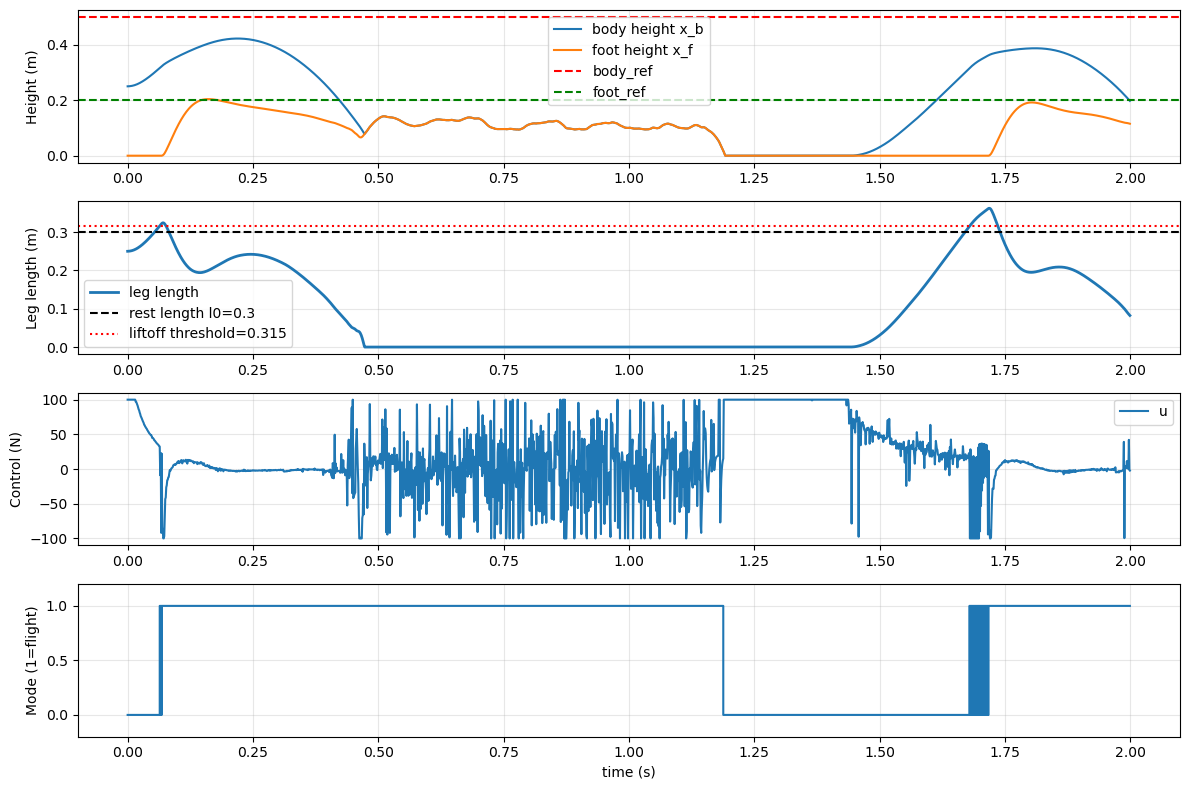

In [6]:
# ======================================================
# Plot results
# ======================================================
time = np.arange(N_sim) * dt_sim
leg_length_hist = x_hist[:,0] - x_hist[:,2]

plt.figure(figsize=(12,8))

plt.subplot(4,1,1)
plt.plot(time, x_hist[:,0], label="body height x_b")
plt.plot(time, x_hist[:,2], label="foot height x_f")
plt.axhline(body_ref, color='r', linestyle='--', label='body_ref')
plt.axhline(foot_ref, color='g', linestyle='--', label='foot_ref')
plt.ylabel("Height (m)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4,1,2)
plt.plot(time, leg_length_hist, label="leg length", linewidth=2)
plt.axhline(l0, color='k', linestyle='--', label=f'rest length l0={l0}')
plt.axhline(l0*1.05, color='r', linestyle=':', label=f'liftoff threshold={l0*1.05:.3f}')
plt.ylabel("Leg length (m)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4,1,3)
plt.plot(time, u_hist, label="u")
plt.ylabel("Control (N)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(4,1,4)
plt.plot(time, [0 if m=="stance" else 1 for m in mode_hist], drawstyle="steps-pre")
plt.ylabel("Mode (1=flight)")
plt.xlabel("time (s)")
plt.ylim(-0.2, 1.2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
